In [1]:
!pip install --pre --user mxnet -f https://dist.mxnet.io/python/cpu

Looking in links: https://dist.mxnet.io/python/cpu
     |████████████████████████████████| 51.4 MB 181 kB/s eta 0:00:01     |████████████████████████        | 38.5 MB 6.2 MB/s eta 0:00:03
     |████████████████████████████████| 98 kB 1.6 MB/s eta 0:00:011
  Created wheel for contextvars: filename=contextvars-2.4-py3-none-any.whl size=7664 sha256=481727e55626ee7344e4c2c93c9ce9733acce20f329baea87d3d713951ca0d4e
  Stored in directory: /home/ec2-user/.cache/pip/wheels/41/11/53/911724983aa48deb94792432e14e518447212dd6c5477d49d3
Successfully built contextvars
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


# Training a Neural Network

We have seen all the components necessary for creating a neural network so we are now ready to move on to an example on how we can create and train a neural network from scratch.

The typical process to create and train a model starts with loading and preparing the datasets. For this Network we will use a [dataset of leaf images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consist of healthy and diseased leaf images of 12 different plant species. To get this dataset we first download and extract the dataset 

In [3]:
!wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip

--2020-08-18 23:27:25--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.105.59
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.105.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7043815070 (6.6G) [application/octet-stream]
Saving to: ‘hb74ynkjcn-1.zip’

hb74ynkjcn-1.zip    100%[===================>]   6.56G  9.24MB/s    in 11m 40s 

2020-08-18 23:39:06 (9.60 MB/s) - ‘hb74ynkjcn-1.zip’ saved [7043815070/7043815070]



In [4]:
!mkdir plants
!unzip hb74ynkjcn-1.zip -d plants
!rm hb74ynkjcn-1.zip

Archive:  hb74ynkjcn-1.zip
   creating: plants/Jatropha (P6)/
   creating: plants/Jatropha (P6)/diseased/
  inflating: plants/Jatropha (P6)/diseased/0018_0045.JPG  
  inflating: plants/Jatropha (P6)/diseased/0018_0081.JPG  
  inflating: plants/Jatropha (P6)/diseased/0018_0009.JPG  
  inflating: plants/Jatropha (P6)/diseased/0018_0063.JPG  
  inflating: plants/Jatropha (P6)/diseased/0018_0108.JPG  
  inflating: plants/Jatropha (P6)/diseased/0018_0027.JPG  
  inflating: plants/Jatropha (P6)/diseased/0018_0054.JPG  
  inflating: plants/Jatropha (P6)/diseased/0018_0090.JPG  
  inflating: plants/Jatropha (P6)/diseased/0018_0018.JPG  
  inflating: plants/Jatropha (P6)/diseased/0018_0072.JPG  
  inflating: plants/Jatropha (P6)/diseased/0018_0117.JPG  
  inflating: plants/Jatropha (P6)/diseased/0018_0036.JPG  
  inflating: plants/Jatropha (P6)/diseased/0018_0089.JPG  
  inflating: plants/Jatropha (P6)/diseased/0018_0010.JPG  
  inflating: plants/Jatropha (P6)/diseased/0018_0098.JPG  
  inflati

If we take a look at the dataset we find that the structure of the directories is as follows

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
        
```

So for each plant species we might have examples of diseased leaves or healthy leaves or both. With this dataset we can formulate different classification problems, for example we can create a multi-class classifier that determines the species of a plant based on the leaves, we can also create a binary classifier that tells you whether the plant is healthy or diseased, finally we could create a multi-class multi-label classifier that tells you both, what species is a plant and whether is diseased or healthy. We will stick with the simplest classification question, which is whether a plant is healthy or not.

To do this we need to manipulate the dataset in two ways. First we need to combine all images of healthy and diseased no matter the species and then we need to split the data in the train, validation and test sets. We prepared a small utility code to get our dataset ready. Once we run that utility code on our data, because our structure will be already organized in folders, we can use the `ImageFolderDataset` class.

In [1]:
import time

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.random.seed(42)

In [2]:
process_dataset('plants')

INFO:root:Starting transferring files from the healthy class
INFO:root:Moving train files
INFO:root:Finished moving train files
INFO:root:Moving validation files
INFO:root:Finished moving validation files
INFO:root:Moving test files
INFO:root:Finished moving test files
INFO:root:Starting transferring files from the diseased class
INFO:root:Moving train files
INFO:root:Finished moving train files
INFO:root:Moving validation files
INFO:root:Finished moving validation files
INFO:root:Moving test files
INFO:root:Finished moving test files
INFO:root:Finished moving files
INFO:root:Removing old folders
INFO:root:Finished!


The new dataset will be located in the `datasets` folder and the new structure looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG

```

Now we just create three different Dataset objects from the `train`, `validation` and `test` folders and the ImageFolderDataset class will take care of inferring the names from the directories.

In [2]:
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this will be a tuple with two elements, the first one is the array of the image and the second one the label for that training example

Data type: <class 'numpy.uint8'>
Label: 0
Label description: diseased


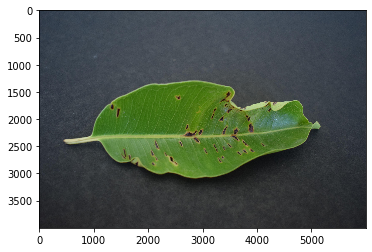

In [3]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")


As you can see from the image. The size is very big 4000 x 6000 pixels. Usually we downsize images before passing to the neural network because that greatly speeds up the training time. It is also customary to make slight modifications to the images to improve generalization. That is why we add transformations to our data in a process called Data Augmentation.

Now that we have the data we can augmented using transforms. We compose two different transformation pipelines, one for training and the other one for validations and testing. This is because we don't need to randomly crop our do color jitter to the images we'll be classifying later on.

In [4]:
from mxnet.gluon.data.vision import transforms

jitter_param = 0.4
lighting_param = 0.1

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize((350, 500)),
    transforms.CenterCrop(224),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(brightness=jitter_param, contrast=jitter_param,
                                 saturation=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize((350, 500)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [5]:
batch_size = 8
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),batch_size=batch_size, shuffle=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer), batch_size=batch_size)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer), batch_size=batch_size)

In [6]:
import numpy as np
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.asnumpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [7]:
for batch in train_loader:
    a = batch
    break

In [8]:
a[1]


[0 1 0 1 0 0 1 0]
<NDArray 8 @cpu(0)>

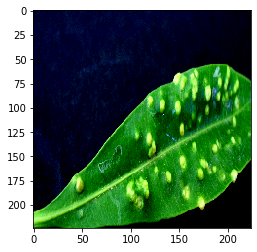

In [9]:
imshow(a[0][7])

In [10]:
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=2, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [11]:
# Train from scratch

ctx = mx.cpu()

# Create NN

class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(512)
        self.dense2 = dense_block(100)
        self.dense3 = nn.Dense(2)
        
    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)
        
        return batch

In [12]:
initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)

In [13]:
model

LeafNetwork(
  (conv1): HybridSequential(
    (0): Conv2D(None -> 32, kernel_size=(2, 2), stride=(1, 1), Activation(relu))
    (1): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
    (2): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  )
  (conv2): HybridSequential(
    (0): Conv2D(None -> 64, kernel_size=(2, 2), stride=(1, 1), Activation(relu))
    (1): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
    (2): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  )
  (conv3): HybridSequential(
    (0): Conv2D(None -> 128, kernel_size=(2, 2), stride=(1, 1), Activation(relu))
    (1): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
    (2): BatchNorm(axis=1, eps=1e-05, momentu

In [14]:
# Learning rate decay factor
lr_decay = 0.001
# Epochs where learning rate decays
lr_decay_epoch = [1, 5, 10, np.inf]

# SGD
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.01}

# Define our trainer for net
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

In [15]:
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

In [16]:
acc_top1 = gluon.metric.Accuracy()

INFO:root:NumPy-shape semantics has been activated in your code. This is required for creating and manipulating scalar and zero-size tensors, which were not supported in MXNet before, as in the official NumPy library. Please DO NOT manually deactivate this semantics while using `mxnet.numpy` and `mxnet.numpy_extension` modules.


In [17]:
def test(ctx, val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data)
        acc.update(labels, outputs)

    _, top1 = acc.get()
    return 1 - top1, top1

In [ ]:
epochs = 2
lr_decay_count = 0
log_interval = 50
lr_decay_period = 0

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    acc_top1.reset()

    if lr_decay_period == 0 and epoch == lr_decay_epoch[lr_decay_count]:
        trainer.set_learning_rate(trainer.learning_rate * lr_decay)
        lr_decay_count += 1

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data)
            loss = loss_fn(outputs, label)
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        acc_top1.update(label, outputs)
        if log_interval and not (idx + 1) % log_interval:
            _, top1 = acc_top1.get()
     
            err_top1 = (1-top1)
            print('Epoch[%d] Batch [%d]     Speed: %f samples/sec   top1-err=%f '%(
                      epoch, idx + 1, batch_size /(time.time()-btic), err_top1))
            btic = time.time()

    _, top1 = acc_top1.get()
    err_top1 = 1-top1

    err_top1_val, acc_val = test(ctx, validation_loader)
    print('[Epoch %d] training: err-top1=%f '%(epoch, err_top1))
    print('[Epoch %d] time cost: %f'%(epoch, time.time()-tic))
    print('[Epoch %d] validation: err-top1=%f validation accuracy=%f'%(epoch, err_top1_val, acc_val))

In [2]:
test(ctx, validation_loader)

NameError: name 'test' is not defined

In [1]:
True

True